In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
# Specify the file path
file_path = 'ML-ResourceScheduler.xlsx'
# read both sheets worker and asset allocation history 
dfs = pd.read_excel(file_path, sheet_name=['Worker Allocation History', 'Asset Allocation History'])
worker_history=dfs['Worker Allocation History']
asset_history=dfs['Asset Allocation History']
# unique_names = worker_history['WorkerSystemID'].unique().tolist() #  the list of unique names of workers 
unique_type = worker_history['WorkerTypeId'].unique().tolist()  #  the list of unique worker type id of workers 
unique_assets = asset_history['AssetID'].unique().tolist()

print(unique_assets) 
print(unique_type)

['CC201', 603, 'FC257', 'FC259', 'FC41', 'FC42', 'FC21', 'FC256', 'FC254', 552, 250, 403, 'FC258', 102, 'FC40', 601, 'XHire Slew', 151, 602, 120, 'FC260', 103, 'XHIRE Franna', 402, 'MC31', 'FC253', 'FC255', 'T7 - STEP DECK', 'Labour', 131, 'FC22', 'FC251', 303, 'XHire Semi', 'Ancilliary Eqpt', 604, 'MR01', 'T8 - FLAT TOP', '131A', '250A', 'P1', '103A', '151A', '102B', 'HR01', '131B', '250C', '250B', '120A', 'LR01', 'FC261']
[1, 7, 2, 3, 9, 5, 0]


In [2]:

transposed_df = pd.read_csv('transposed_dataframe.csv')
worker_ids = transposed_df['AssetID']
df_t = transposed_df.drop('AssetID', axis=1)
df_t.columns = df_t.columns.astype(str)
df_t =df_t.apply(pd.to_numeric)  

In [3]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=len(unique_assets + unique_type[:-1]), random_state=0).fit(df_t) #initialised n clusters which is equal to number of possibles working workerids
df_t['cluster'] = kmeans.labels_       #initialise and update model with data to train

In [19]:
import joblib

# Save the model if trained
joblib.dump(kmeans, 'kmeans_model.pkl')

# Load the model from directory 
kmeans_loaded = joblib.load('kmeans_model.pkl')


Inertia: 0.0


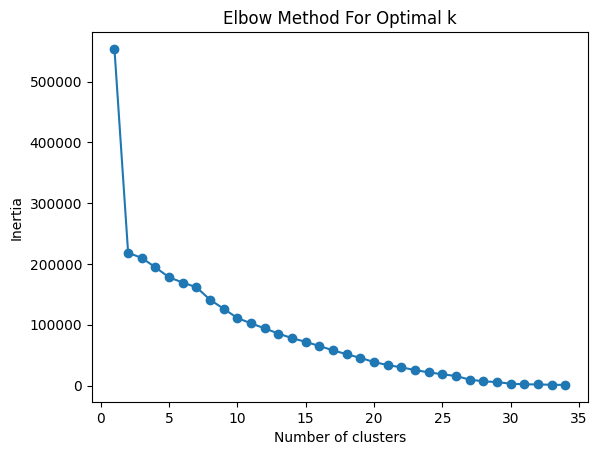

In [27]:
# Load the model
import joblib
kmeans_loaded = joblib.load('kmeans_model.pkl')
# Compute the inertia
inertia = kmeans_loaded.inertia_
print(f'Inertia: {inertia}')
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt

# Compute KMeans for different number of clusters
inertia_values = []
range_clusters = range(1,35)
for k in range_clusters:
    kmeanss = KMeans(n_clusters=k, random_state=0).fit(df_t)
    inertia_values.append(kmeanss.inertia_)

# Plot the inertia values to visualize the elbow point
plt.plot(range_clusters, inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()



In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
silhouette_avg = silhouette_score(df_t, kmeanss.labels_)
db_score = davies_bouldin_score(df_t, kmeanss.labels_)
inertia = kmeanss.inertia_

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_score}')
print(f'Inertia: {inertia}')

Silhouette Score: 0.31110875584881503
Davies-Bouldin Index: 0.4038333232123747
Inertia: 8671.022222222224


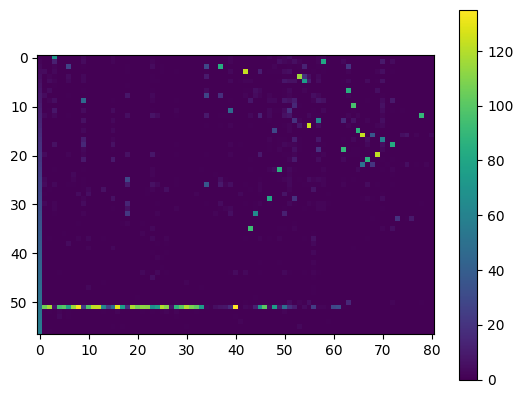

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data is in a NumPy array called 'data'
# this shows data distribution
plt.imshow(transposed_df, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()


In [25]:
# def recommend_assets( id, df, num_recommendations=25):
#     recommended_assets_dict = {}
#     # Find the cluster for the given asset
#     column_list = unique_assets + unique_type[:-1]
#     column_list = [str(element) for element in column_list]
#     for i in id:  #this column is for asset ids and works
#         index = column_list.index(i)
#         asset_cluster = df.loc[worker_ids == index+1, 'cluster'].values[0]
        
#         # Find assets in the same cluster
#         similar_assets = df[df['cluster'] == asset_cluster].drop(columns=['cluster'])
        
#         asset_recommendations = similar_assets.mean().sort_values(ascending=False)
        
#         # Recommend the top N assets
#         recommended_assets = asset_recommendations.index[:num_recommendations].tolist()
#         recommended_assets_dict[i] = recommended_assets

#     return recommended_assets_dict 



In [26]:
# asset_id = ["9","2",'XHire Slew']
# recommended_assets = recommend_assets(asset_id , df_t)
# # print(f"Recommended workers for asset : {recommended_assets}")
# for key, value in recommended_assets.items():
#     print(f"Role: {key}, Recommended Workers ID: {value}")

Role: 9, Recommended Workers ID: ['314', '350', '426', '321', '296', '302', '313', '422', '415', '425', '375', '372', '420', '391', '376', '409', '373', '365', '364', '307', '424', '303', '345', '423', '360']
Role: 2, Recommended Workers ID: ['409', '391', '421', '427', '313', '296', '422', '302', '425', '372', '375', '420', '364', '365', '376', '415', '373', '350', '307', '426', '424', '303', '345', '423', '360']
Role: XHire Slew, Recommended Workers ID: ['377', '390', '413', '385', '389', '383', '302', '422', '425', '372', '313', '409', '296', '391', '376', '415', '373', '350', '365', '364', '420', '375', '426', '423', '297']


In [27]:

def recommend_assets(ids, df, kmeans_model, num_recommendations=25):
    recommended_assets_dict = {}
    
    # Make sure to use the columns excluding 'cluster'
    column_list = unique_assets + unique_type[:-1]
    column_list = [str(element) for element in column_list]
    
    for i in ids:  # this column is for asset ids and works
        index = column_list.index(i)
        
        # Select the correct row and exclude the 'cluster' column
        asset_data = df.drop(columns=['cluster']).iloc[index].values.reshape(1, -1)
        
        # Predict the cluster for the asset using the trained model
        asset_cluster = kmeans_model.predict(asset_data)[0]
        
        # Find assets in the same cluster
        similar_assets = df[df['cluster'] == asset_cluster].drop(columns=['cluster'])
        
        asset_recommendations = similar_assets.mean().sort_values(ascending=False)
        
        # Recommend the top N assets
        recommended_assets = asset_recommendations.index[:num_recommendations].tolist()
        recommended_assets_dict[i] = recommended_assets

    return recommended_assets_dict


In [28]:
# Load the model from directory 
kmeans_loaded = joblib.load('kmeans_model.pkl')

asset_id = ["9","2",'XHire Slew']
recommended_assets = recommend_assets(asset_id , df_t,kmeans_loaded)
# print(f"Recommended workers for asset : {recommended_assets}")
for key, value in recommended_assets.items():
    print(f"Role: {key}, Recommended Workers ID: {value}")


Role: 9, Recommended Workers ID: ['314', '350', '426', '321', '296', '302', '313', '422', '415', '425', '375', '372', '420', '391', '376', '409', '373', '365', '364', '307', '424', '303', '345', '423', '360']
Role: 2, Recommended Workers ID: ['409', '391', '421', '427', '313', '296', '422', '302', '425', '372', '375', '420', '364', '365', '376', '415', '373', '350', '307', '426', '424', '303', '345', '423', '360']
Role: XHire Slew, Recommended Workers ID: ['377', '390', '413', '385', '389', '383', '302', '422', '425', '372', '313', '409', '296', '391', '376', '415', '373', '350', '365', '364', '420', '375', '426', '423', '297']


e:\work\recommendation_system\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
e:\work\recommendation_system\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
e:\work\recommendation_system\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
